# Jagged reduction

Given a jagged array, we want to compute a reduction (e.g. `sum` or `max`) as quickly as possible. We'll study the naive sequential algorithm, Jaydeep's modified Hillis-Steele on GPU and AVX-512. As a further modification, we replace the offsets-driven gather with a parents-driven scatter, since the extra pass gather was found to be dominant over the reduction itself.

## First step: prepare data

The jagged datasets are Gaussian random numbers in Poisson-distributed groups, a different dataset for each Poisson-average group size. To make debugging easier, the Gaussian numbers will be 1 +- 0.01 (the sum will always be approximately equal to the count), and there will be 15 samples with logarithmically spaced Poisson-averages:

    0.3 0.5 1.0 2.0 3.0 5.0 10.0 20.0 30.0 50.0 100.0 200.0 300.0 500.0 1000.0

This is about 20 GB (15 GB inputs + 5 GB outputs), and we'll cache them on disk (in `/tmp/DATA`).

In [1]:
import numpy
import os

In [2]:
tasksize = 100000000

def make_dataset(averagesize, location="/tmp/DATA"):
    if not os.path.exists(location):
        os.mkdir(location)
    counts = numpy.random.poisson(averagesize, int(numpy.ceil(tasksize / averagesize)))
    offsets = numpy.empty(len(counts) + 1, dtype=numpy.int32)
    offsets[0] = 0
    numpy.cumsum(counts, out=offsets[1:])
    del counts
    with open(os.path.join(location, "offsets-{}".format(averagesize)), "wb") as f:
        offsets.tofile(f)

    parents = numpy.zeros(len(content), dtype=numpy.int32)
    numpy.add.at(parents, offsets[offsets != offsets[-1]][1:], 1)
    numpy.cumsum(parents, out=parents)
    with open(os.path.join(location, "parents-{}".format(averagesize)), "wb") as f:
        parents.tofile(f)
    del parents
    
    content = numpy.random.normal(1, 0.01, offsets[-1]).astype(numpy.float32)
    with open(os.path.join(location, "content-{}".format(averagesize)), "wb") as f:
        content.tofile(f)
    del content
    del offsets

averagesizes = 0.3, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0, 30.0, 50.0, 100.0, 200.0, 300.0, 500.0, 1000.0

In [3]:
def get_dataset(averagesize, location="/tmp/DATA"):
    offsets = numpy.fromfile(open(os.path.join(location, "offsets-{}".format(averagesize))),
                             dtype=numpy.int32)
    parents = numpy.fromfile(open(os.path.join(location, "parents-{}".format(averagesize))),
                             dtype=numpy.int32)
    content = numpy.fromfile(open(os.path.join(location, "content-{}".format(averagesize))),
                             dtype=numpy.float32)
    return offsets, parents, content

## Sequential algorithm

This is the natural algorithm, stepping through jagged subcollections in a doubly nested for loop. We also use it to define the "correct" output. We'll study two such algorithms, `sum` and `max`.

The `-O3` optimization and `-ftree-vectorize` flags are on, though this loop can't be vectorized because of the loop-carried dependency.

In [4]:
%load_ext Cython

In [5]:
%%cython -c-O3 -c-ftree-vectorize

from libc.stdint cimport int32_t
from libc.math cimport INFINITY

cdef extern from "":
    """
void sequential_sum_impl(int32_t len_offsets, int32_t* offsets, float* content, float* output) {
    for (int i = 0;  i < len_offsets - 1;  i++) {
        output[i] = 0.0;
        for (int j = offsets[i];  j < offsets[i + 1];  j++) {
            output[i] += content[j];
        }
    }
}

void sequential_max_impl(int32_t len_offsets, int32_t* offsets, float* content, float* output) {
    for (int i = 0;  i < len_offsets - 1;  i++) {
        output[i] = -INFINITY;
        for (int j = offsets[i];  j < offsets[i + 1];  j++) {
            if (content[j] > output[i]) {
                output[i] = content[j];
            }
        }
    }
}
"""
    void sequential_sum_impl(int32_t len_offsets, int32_t* offsets, float* content, float* output)
    void sequential_max_impl(int32_t len_offsets, int32_t* offsets, float* content, float* output)

def sequential_sum(offsets, parents, content, output):
    sequential_sum_impl(len(offsets),
                        <int32_t*>(<size_t>offsets.ctypes.data),
                        <float*>(<size_t>content.ctypes.data),
                        <float*>(<size_t>output.ctypes.data))

def sequential_max(offsets, parents, content, output):
    sequential_max_impl(len(offsets),
                        <int32_t*>(<size_t>offsets.ctypes.data),
                        <float*>(<size_t>content.ctypes.data),
                        <float*>(<size_t>output.ctypes.data))

In [6]:
import gc
def define_correct(averagesize, location="/tmp/DATA"):
    offsets, parents, content = get_dataset(averagesize, location=location)
    output = numpy.empty(len(offsets) - 1, dtype=numpy.float32)
    sequential_sum(offsets, parents, content, output)
    with open(os.path.join(location, "sum-{}".format(averagesize)), "wb") as f:
        output.tofile(f)
    sequential_max(offsets, parents, content, output)
    with open(os.path.join(location, "max-{}".format(averagesize)), "wb") as f:
        output.tofile(f)
    del offsets, parents, content, output
    gc.collect()

## Measure time

We'll use wall time of 3 repetitions, not counting data-loading or memory allocation.

In [7]:
import time

def measure(averagesize, run, times=10, location="/tmp/DATA"):
    offsets, parents, content = get_dataset(averagesize, location=location)
    output = numpy.empty(len(offsets) - 1, dtype=numpy.float32)
    cumulative = 0.0
    for i in range(times):
        start = time.time()
        run(offsets, parents, content, output)
        cumulative += time.time() - start
    del offsets, parents, content, output
    gc.collect()
    return tasksize * times * 1e-6 / cumulative   # MHz in number of particles (not events)

In [103]:
import pandas

sum_rates = pandas.DataFrame(index=averagesizes, columns=["sequential"])
max_rates = pandas.DataFrame(index=averagesizes, columns=["sequential"])
sum_rates.index.name = "average number of items per group"
max_rates.index.name = "average number of items per group"

In [9]:
%matplotlib inline

## Sequential algorithm 2: scatter from parents

The first sequential algorithm determined which items belong in which group from the `offsets` array, but it could have made that determination from the `parents` array. The `parents` array is aligned with `content` and will be crucial to the vectorized algorithms.

In [10]:
%%cython -c-O3 -c-ftree-vectorize

from libc.stdint cimport int32_t
from libc.math cimport INFINITY

cdef extern from "":
    """
void sequential2_sum_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output) {
    for (int i = 0;  i < len_offsets - 1;  i++) {
        output[i] = 0.0;
    }
    int32_t lastparent = -1;
    float cumulative = 0.0;
    int i;
    for (i = 0;  i < len_parents;  i++) {
        if (lastparent != -1  &&  lastparent != parents[i]) {
            output[lastparent] = cumulative;
            cumulative = 0.0;
        }
        cumulative += content[i];
        lastparent = parents[i];
    }
    if (lastparent != -1) {
        output[lastparent] = cumulative;
    }
}

void sequential2_max_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output) {
    for (int i = 0;  i < len_offsets - 1;  i++) {
        output[i] = -INFINITY;
    }
    int32_t lastparent = -1;
    float cumulative = -INFINITY;
    int i;
    for (i = 0;  i < len_parents;  i++) {
        if (lastparent != -1  &&  lastparent != parents[i]) {
            output[lastparent] = cumulative;
            cumulative = -INFINITY;
        }
        if (content[i] > cumulative) {
            cumulative = content[i];
        }
        lastparent = parents[i];
    }
    if (lastparent != -1) {
        output[lastparent] = cumulative;
    }
}
"""
    void sequential2_sum_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output)
    void sequential2_max_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output)

def sequential2_sum(offsets, parents, content, output):
    sequential2_sum_impl(len(offsets),
                         len(parents),
                         <int32_t*>(<size_t>parents.ctypes.data),
                         <float*>(<size_t>content.ctypes.data),
                         <float*>(<size_t>output.ctypes.data))

def sequential2_max(offsets, parents, content, output):
    sequential2_max_impl(len(offsets),
                         len(parents),
                         <int32_t*>(<size_t>parents.ctypes.data),
                         <float*>(<size_t>content.ctypes.data),
                         <float*>(<size_t>output.ctypes.data))

This is a new algorithm, so we must verify its correctness. In general (not this case), different algorithms add numbers in a different order, so we have to allow for small errors due to the non-associativity of floating-point addition.

In [98]:
import gc
def verify_correct(averagesize, run, which, location="/tmp/DATA"):
    offsets, parents, content = get_dataset(averagesize, location=location)
    output = numpy.empty(len(offsets) - 1, dtype=numpy.float32)
    run(offsets, parents, content, output)
    original = numpy.fromfile(open(os.path.join(location, "{}-{}".format(which, averagesize)), "rb"),
                              dtype=numpy.float32)
    mask1 = numpy.isfinite(output)
    mask2 = numpy.isfinite(original)
    if not numpy.array_equal(mask1, mask2) or numpy.absolute(output[mask1] - original[mask2]).max() > 0.003:
        print("averagesize {} {} is not correct".format(averagesize, which))
        return offsets, parents, content, output, original
    del offsets, parents, content, output, original
    gc.collect()
    return None, None, None, None, None

Now we can measure its performance.

## Vectorized by 16

Below, Jaydeep's vectorized jagged reduction is implemented for a vector size of 16 items. Since these are 32-bit integers and floats, that means a 512-bit vector register (AVX-512). The code below won't work on CPUs without AVX-512 instructions. Smaller vector units give less of a speedup because this algorithm approaches the sequential case as the vector size → one item.

In [88]:
%%cython --cplus -Ivectorclass -c-O3 -c-ftree-vectorize

cdef extern from "":
    "#define MAX_VECTOR_SIZE 512"   # must be defined before including vectorclass

from libc.stdint cimport int32_t
from libc.math cimport INFINITY

cdef extern from "vectorclass.h":
    """
void vectorized16_sum_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output) {
    for (int i = 0;  i < len_offsets - 1;  i++) {
        output[i] = 0.0;
    }
    
    Vec16f s;
    Vec16f scarry = {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0};
    Vec16i p;
    Vec16i pcarry = {-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1};

    Vec16i p2;
    Vec16i p2none = {-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1};

    for (int i = 0;  i < len_parents;  i += 16) {
        s.load(&content[i]);
        p.load(&parents[i]);
        p2.load(&parents[i + 1]);

        s = if_add(p == pcarry, s, scarry);

        s = if_add(p == permute16i<-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14>(p),
                   s,   permute16f<-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14>(s));

        s = if_add(p == permute16i<-1, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13>(p),
                   s,   permute16f<-1, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13>(s));

        s = if_add(p == permute16i<-1, -1, -1, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11>(p),
                   s,   permute16f<-1, -1, -1, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11>(s));

        s = if_add(p == permute16i<-1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  2,  3,  4,  5,  6,  7>(p),
                   s,   permute16f<-1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  2,  3,  4,  5,  6,  7>(s));

        scarry = permute16f<15, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1>(s);
        pcarry = permute16i<15, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1>(p);

        scatter(select(p == p2, p2none, p), len_offsets, s, output);
    }
}

void vectorized16_max_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output) {
    for (int i = 0;  i < len_offsets - 1;  i++) {
        output[i] = -INFINITY;
    }
    
    Vec16f s;
    Vec16f scarry = {-INFINITY, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0};
    Vec16i p;
    Vec16i pcarry = {-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1};

    Vec16i p2;
    Vec16i p2none = {-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1};

    for (int i = 0;  i < len_parents;  i += 16) {
        s.load(&content[i]);
        p.load(&parents[i]);
        p2.load(&parents[i + 1]);

        s = select(p == pcarry, s, scarry);

        s = select(p == permute16i<-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14>(p),
                   s,   permute16f<-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14>(s));

        s = select(p == permute16i<-1, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13>(p),
                   s,   permute16f<-1, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13>(s));

        s = select(p == permute16i<-1, -1, -1, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11>(p),
                   s,   permute16f<-1, -1, -1, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11>(s));

        s = select(p == permute16i<-1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  2,  3,  4,  5,  6,  7>(p),
                   s,   permute16f<-1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  2,  3,  4,  5,  6,  7>(s));

        scarry = permute16f<15, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1>(s);
        pcarry = permute16i<15, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1>(p);

        scatter(select(p == p2, p2none, p), len_offsets, s, output);
    }
}

"""
    void vectorized16_sum_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output)
    void vectorized16_max_impl(int32_t len_offsets, int32_t len_parents, int32_t* parents, float* content, float* output)

def vectorized16_sum(offsets, parents, content, output):
    vectorized16_sum_impl(len(offsets),
                          len(parents),
                          <int32_t*>(<size_t>parents.ctypes.data),
                          <float*>(<size_t>content.ctypes.data),
                          <float*>(<size_t>output.ctypes.data))

def vectorized16_max(offsets, parents, content, output):
    vectorized16_max_impl(len(offsets),
                          len(parents),
                          <int32_t*>(<size_t>parents.ctypes.data),
                          <float*>(<size_t>content.ctypes.data),
                          <float*>(<size_t>output.ctypes.data))

In [100]:
for averagesize in averagesizes:
    print(averagesize)
    offsets, parents, content, output, original = verify_correct(averagesize, vectorized16_sum, "sum")
    if output is not None:
        break

0.3
0.5
1.0
2.0
3.0
5.0
10.0
20.0
30.0
50.0
100.0
200.0
300.0
500.0
1000.0


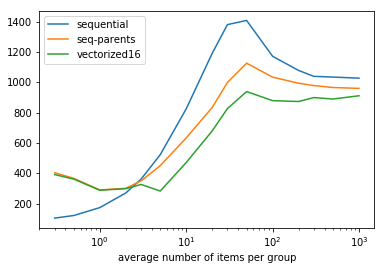

In [107]:
sum_rates.plot(logx=True)

In [ ]:
max_rates.plot(logx=True)